In [2]:
from iris_lmsalpy import hcr2fits, extract_irisL2data
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.cluster import KMeans, MiniBatchKMeans
from ipywidgets import interact

%matplotlib inline

# query_text = "https://www.lmsal.com/hek/hcr?cmd=search-events3&outputformat=json&startTime=2017-10-25T04:00&stopTime=2017-10-25T05:00&minnumRasterSteps=320&herEvents=SS&hasData=true&limit=200"
# list_urls = hcr2fits.get_fits(query_text)



The provided file is a raster IRIS Level 2 data file.

Extracting information from file iris_l2_20160114_230409_3630008076_raster_t000_r00000.fits... 

Available data with size Y x X x Wavelength are stored in windows labeled as:

--------------------------------------------------------------------
Index --- Window label --- Y x X x WL --- Spectral range [AA] (band)
--------------------------------------------------------------------
  0 	 C II 1336    	   779x320x374 	   1332.66 - 1337.50  (FUV)
  1 	 Fe XII 1349  	   779x320x245 	   1347.62 - 1350.79  (FUV)
  2 	 O I 1356     	   779x320x340 	   1352.19 - 1356.59  (FUV)
  3 	 Si IV 1394   	   779x320x411 	   1390.87 - 1396.08  (FUV)
  4 	 Si IV 1403   	   779x320x602 	   1398.59 - 1406.23  (FUV)
  5 	 2832         	   779x320x113 	   2831.38 - 2834.23  (NUV)
  6 	 2814         	   779x320x146 	   2812.69 - 2816.38  (NUV)
  7 	 Mg II k 2796 	   779x320x530 	   2793.14 - 2806.61  (NUV)
------------------------------------------------

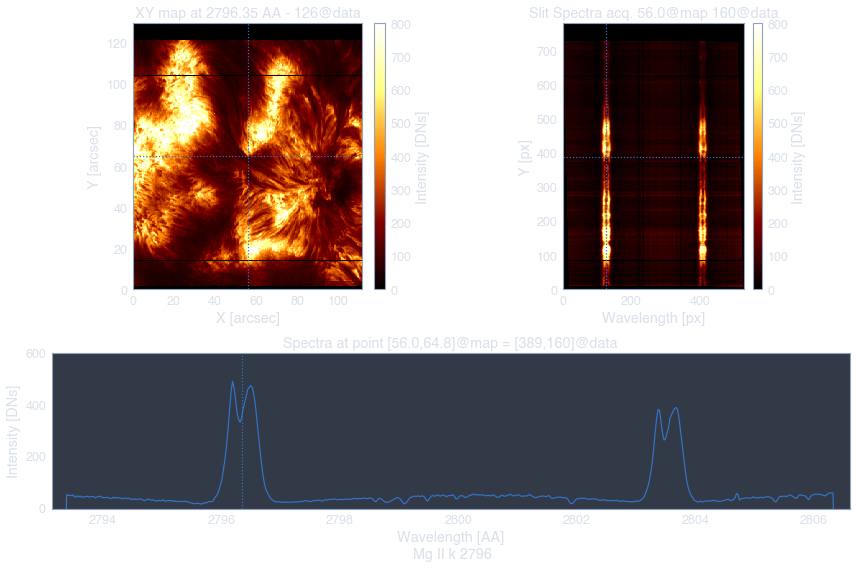

<Figure size 432x288 with 0 Axes>

In [3]:
raster_filename = "iris_l2_20160114_230409_3630008076_raster_t000_r00000.fits"
iris_raster = extract_irisL2data.load(
    raster_filename, window_info=['Mg II k 2796'], verbose=True
)
iris_raster.quick_look()

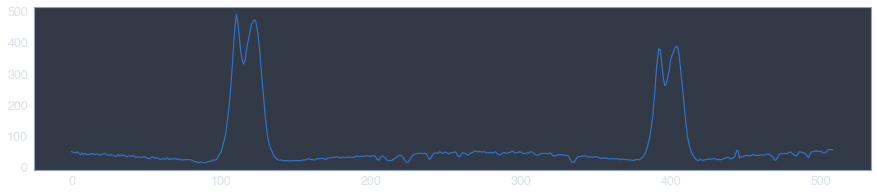

In [4]:
r = iris_raster.raster['Mg II k 2796']
s = r.data.shape
d = r.data[s[0]//2, s[1]//2, :]
d = d[d>0]
best = np.argmin(d)

plt.figure(figsize=(15,3))
plt.plot(d)

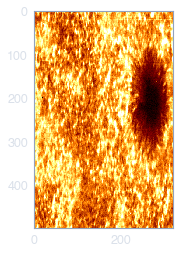

In [5]:
data = r.data[100:600, :, :]
plt.imshow(data[:, :, best], cmap=r.cmap)
plt.clim([0, 50])

In [124]:
def clean_image(w):
    ret, masked_image = cv2.threshold(w, 0, 255, cv2.THRESH_BINARY)
    kernel = np.ones((3,3),np.uint8)

    masked_image = cv2.morphologyEx(masked_image, cv2.MORPH_OPEN, kernel, iterations=1)
    masked_image = cv2.morphologyEx(masked_image, cv2.MORPH_CLOSE, kernel, iterations=1)
    
    return masked_image

In [148]:
def cluster(pixels, num_clusters):
    mbkm = MiniBatchKMeans(
        n_clusters=num_clusters,
        n_init=10
    )

    y_mbkm = mbkm.fit_predict(pixels)

    km = KMeans(
        n_clusters=num_clusters,
        init=mbkm.cluster_centers_,
        n_init=1
    )

    y_km = km.fit_predict(pixels)
    
    return (km, y_km)

In [149]:
def elbow_kmeans(pixels, num_clusters):
    distortions = []
    for i in range(30, 131, 10):
        km = KMeans(
            n_clusters=num_clusters
        )
        km.fit(pixels)
        distortions.append(km.inertia_)
        print(i, end=" ")

    plt.plot(range(30, 131, 10), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()

In [150]:
def sort_clusters_by_size(y_km, num_clusters):
    counts = []
    for i in range(num_clusters):
        counts.append((i, np.count_nonzero(y_km==i)))

    sorted_counts = sorted(counts, key = lambda i: i[1], reverse=True)
    return sorted_counts

In [151]:
def graph_all_clusters(km, y_km, pixels, sorted_counts, num_clusters, 
                       overlay_all=False, ylim=None):
    # TODO: fix this subplot creation
    f, axes = plt.subplots(10, num_clusters//10, sharey=True, sharex=True, figsize=(20,20))
    axes = np.ravel(axes)
    for i in range(num_clusters):
        if overlay_all:
            print(i, end=" ")
            for p in pixels[y_km==i]:
                axes[i].plot(p, c="b", alpha=0.2)

        axes[i].plot(km.cluster_centers_[sorted_counts[i][0]], c="white", lw=2)
        axes[i].set_title("C{} N{}".format(sorted_counts[i][0], sorted_counts[i][1]))
        
        if ylim:
            axes[i].set_ylim(ylim)

In [152]:
def interactive_cluster_slider(y_km, km, pixels_loc, masked_image, num_clusters):
    @interact(c=(0, num_clusters-1))
    def double_number(c):
        in_cluster = pixels_loc[y_km==c]
        y,x = zip(*in_cluster)
        f, axes = plt.subplots(1,2,figsize=(12.8,10))
        axes[0].scatter(x,y, s=1, zorder=1)
        axes[0].set_xlim(0, masked_image.shape[1])
        axes[0].set_ylim(masked_image.shape[0], 0)

        implot = axes[0].imshow(data[:, :, best], cmap=r.cmap)
        implot.set_clim([0, 50])

        axes[1].plot(km.cluster_centers_[c])

In [177]:
def run_clustering(w, num_clusters):
    masked_image = clean_image(w)
    pixels, pixels_loc = create_pixels(masked_image)
    km, y_km = cluster(pixels, num_clusters)
    # elbow_kmeans(pixels, num_clusters)
    sorted_counts = sort_clusters_by_size(y_km, num_clusters)
    graph_all_clusters(km, y_km, pixels, sorted_counts, num_clusters, ylim=(0,700))
    interactive_cluster_slider(y_km, km, pixels_loc, masked_image, num_clusters)
    
    return masked_image

In [178]:
def create_pixels(masked_image):
    cutoffs = [0, 10000]
    for i in range(masked_image.shape[0]):
        for j in range(masked_image.shape[1]):
            if masked_image[i,j]:
                d = np.where(data[i, j, :] > 0)[0]
                cutoffs[0] = max(d[0], cutoffs[0])
                cutoffs[1] = min(d[-1], cutoffs[1])
    pixels = []
    pixels_loc = []
    for i in range(masked_image.shape[0]):
        for j in range(masked_image.shape[1]):
            if masked_image[i,j]:
                d = data[i, j, cutoffs[0]:cutoffs[1]]
                pixels.append(d)
                pixels_loc.append((i,j))
    pixels = np.stack(pixels, axis=0)
    pixels_loc = np.array(pixels_loc)
    return (pixels, pixels_loc)

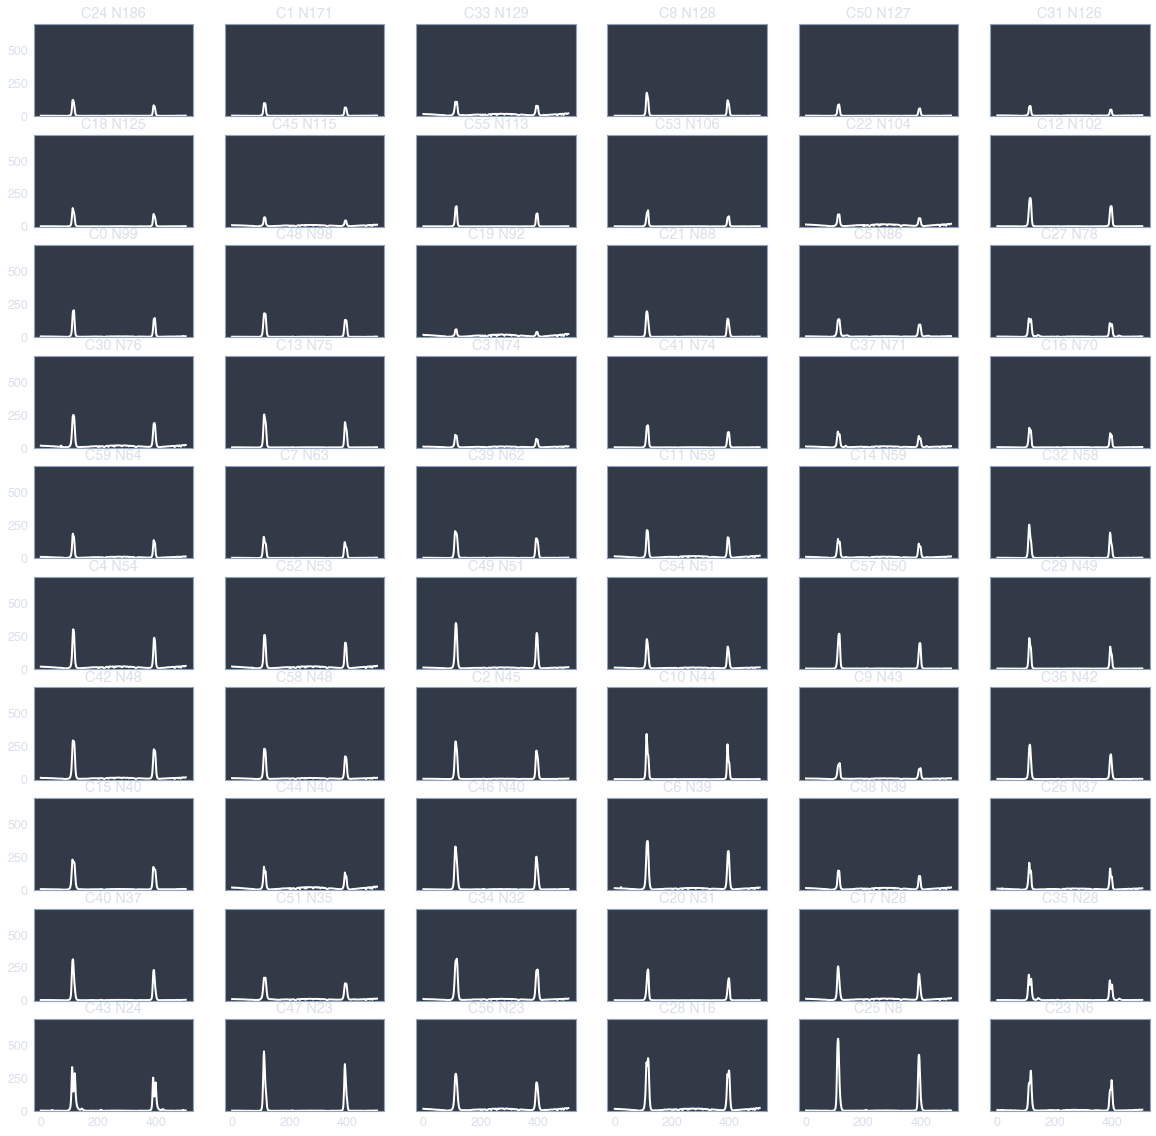

interactive(children=(IntSlider(value=29, description='c', max=59), Output()), _dom_classes=('widget-interact'…

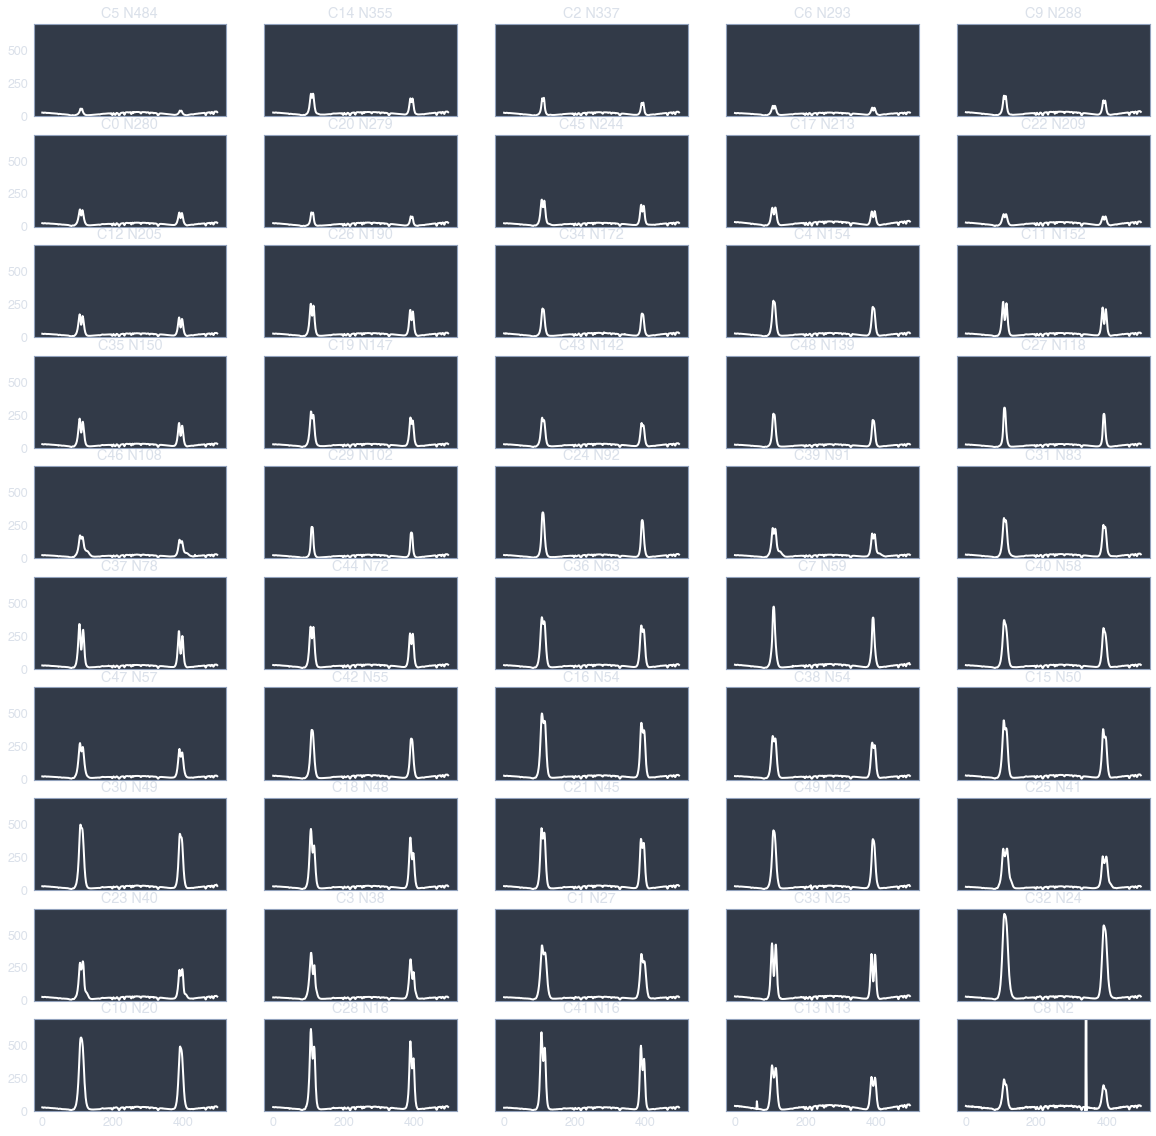

interactive(children=(IntSlider(value=24, description='c', max=49), Output()), _dom_classes=('widget-interact'…

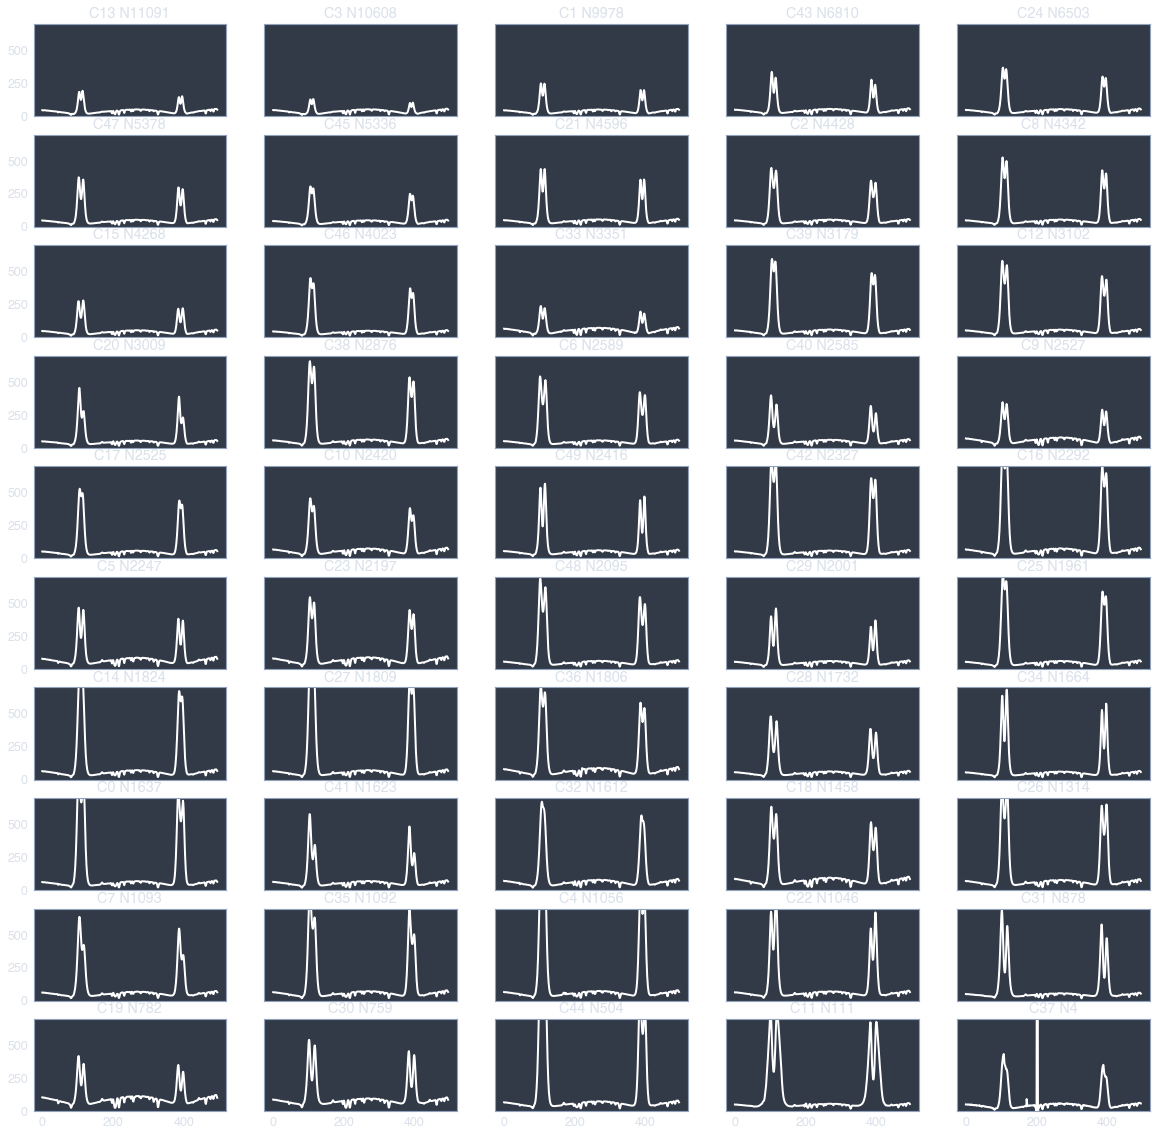

interactive(children=(IntSlider(value=24, description='c', max=49), Output()), _dom_classes=('widget-interact'…

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


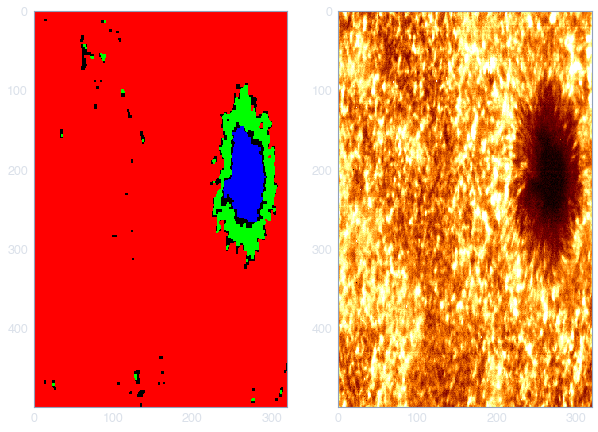

In [179]:
a = data[:, :, best]
i = np.unravel_index(a[a>0].argmax(), a.shape)
m = a[i[0],i[1]]
# umbra
mask_umbra = a < (m * 0.2)
# penumbra
mask_penumbra = (a > (m * 0.2)) & (a < (m * 0.4))
# quiet
mask_quiet = a > m * 0.4
cluster_counts = [60, 50, 50]
colors = [(0, 0, 255), (0, 255, 0), (255, 0, 0)]

blank_image = np.zeros(shape=[*a.shape, 3], dtype=np.float32)

for i, m in enumerate([mask_umbra, mask_penumbra, mask_quiet]):
    w = np.where(m, a, 0)
    mask = run_clustering(w, cluster_counts[i])
    rgb = cv2.cvtColor(mask,cv2.COLOR_GRAY2RGB)
    rgb[mask > 0] = colors[i]
    blank_image = cv2.bitwise_or(blank_image, rgb)

f, axes = plt.subplots(1, 2, figsize=(10,10))
axes[0].imshow(blank_image)
implot = axes[1].imshow(data[:, :, best], cmap=r.cmap)
implot.set_clim([0, 50])
plt.show()

In [17]:
del iris_raster
del r, d, data

NameError: name 'iris_raster' is not defined